# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [18]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as mse

In [29]:
class GradientBoosting:
    def __init__(self, n_estimators=100, max_depth=100, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.loss = mse
        self.gammas = []
        self.trees = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = y
        s = 0
        
        
        for i in range(self.n_estimators):
            s += self._fit_predict_tree(x, y_new)
            y_new = 2*(y - s)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        
        h0 = np.ones_like(y) * y.mean()
        H = self.learning_rate * h0
        
        L = lambda g: self.loss(y, H + g * tree.predict(x)).mean()
        res = minimize(L, x0=0.0)
        g = res.x[0]
        
        self.trees.append(tree)
        self.gammas.append(g)
        return g * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = 0
        for tree, g in zip(self.trees, self.gammas):
            y_pred += g * self.learning_rate * tree.predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [8]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [66]:
np.random.seed(19052019)
df1 = pd.DataFrame([], columns=['n_estimators', 'max_depth', 'mse'])
for i in range(50, 70):
    for j in range(5, 10):
        gdb = GradientBoosting(n_estimators = i, max_depth = j)
        gdb.fit(X_train, y_train)
        new_row = {'n_estimators': i, 'max_depth': j, 'mse': mean_squared_error(y_test, gdb.predict(X_test))}
        df1 = df1.append([new_row])
df1[df1['mse']==df1['mse'].min()]

,n_estimators,max_depth,mse
0,59,6,9.528825


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

победили RandomForestRegressor

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [41]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [42]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [51]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.706105165582452

In [53]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor()

In [54]:
from sklearn.preprocessing import LabelEncoder
for col in train.select_dtypes(exclude=[np.number]).columns:
    train[col] = LabelEncoder().fit_transform(train[col])

In [55]:
X_train, y_train = train.drop('dep_delayed_15min', 1), train['dep_delayed_15min']

In [28]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [77]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2) }
cat = CatBoostRegressor()
clf = GridSearchCV(cat, parametrs)
clf.fit(X_valid, y_valid)
clf.best_params_

Learning rate set to 0.5
0:	learn: 0.3849382	total: 22.5ms	remaining: 202ms
1:	learn: 0.3821233	total: 25ms	remaining: 100ms
2:	learn: 0.3806560	total: 27.4ms	remaining: 64ms
3:	learn: 0.3798868	total: 29.3ms	remaining: 43.9ms
4:	learn: 0.3791593	total: 30.9ms	remaining: 30.9ms
5:	learn: 0.3786283	total: 32.6ms	remaining: 21.8ms
6:	learn: 0.3783124	total: 34.3ms	remaining: 14.7ms
7:	learn: 0.3781322	total: 36ms	remaining: 9.01ms
8:	learn: 0.3779605	total: 37.7ms	remaining: 4.18ms
9:	learn: 0.3777826	total: 39.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3855240	total: 1.53ms	remaining: 13.8ms
1:	learn: 0.3826628	total: 3.2ms	remaining: 12.8ms
2:	learn: 0.3810647	total: 4.95ms	remaining: 11.6ms
3:	learn: 0.3801342	total: 6.59ms	remaining: 9.89ms
4:	learn: 0.3792179	total: 8.29ms	remaining: 8.29ms
5:	learn: 0.3786688	total: 10.3ms	remaining: 6.89ms
6:	learn: 0.3782624	total: 12ms	remaining: 5.12ms
7:	learn: 0.3780821	total: 13.6ms	remaining: 3.39ms
8:	learn: 0.3778887	total: 1

9:	learn: 0.3777826	total: 16ms	remaining: 31.9ms
10:	learn: 0.3776546	total: 17.6ms	remaining: 30.5ms
11:	learn: 0.3775401	total: 19.3ms	remaining: 29ms
12:	learn: 0.3774620	total: 21.2ms	remaining: 27.7ms
13:	learn: 0.3773109	total: 22.9ms	remaining: 26.2ms
14:	learn: 0.3772257	total: 24.6ms	remaining: 24.6ms
15:	learn: 0.3771718	total: 26.3ms	remaining: 23ms
16:	learn: 0.3769137	total: 27.9ms	remaining: 21.4ms
17:	learn: 0.3768489	total: 29.6ms	remaining: 19.7ms
18:	learn: 0.3767757	total: 31.3ms	remaining: 18.1ms
19:	learn: 0.3766913	total: 33ms	remaining: 16.5ms
20:	learn: 0.3765983	total: 34.6ms	remaining: 14.8ms
21:	learn: 0.3764986	total: 36.2ms	remaining: 13.2ms
22:	learn: 0.3764213	total: 37.8ms	remaining: 11.5ms
23:	learn: 0.3763324	total: 39.3ms	remaining: 9.84ms
24:	learn: 0.3762577	total: 41ms	remaining: 8.19ms
25:	learn: 0.3761819	total: 42.5ms	remaining: 6.54ms
26:	learn: 0.3761005	total: 44ms	remaining: 4.89ms
27:	learn: 0.3760470	total: 45.7ms	remaining: 3.26ms
28:	le

0:	learn: 0.3864954	total: 1.47ms	remaining: 57.2ms
1:	learn: 0.3839173	total: 3.15ms	remaining: 59.9ms
2:	learn: 0.3822006	total: 4.87ms	remaining: 60.1ms
3:	learn: 0.3813340	total: 6.52ms	remaining: 58.7ms
4:	learn: 0.3805278	total: 8.18ms	remaining: 57.3ms
5:	learn: 0.3798960	total: 9.87ms	remaining: 56ms
6:	learn: 0.3796675	total: 11.5ms	remaining: 54.3ms
7:	learn: 0.3794072	total: 13.2ms	remaining: 52.8ms
8:	learn: 0.3793623	total: 14.9ms	remaining: 51.5ms
9:	learn: 0.3792109	total: 16.7ms	remaining: 50.1ms
10:	learn: 0.3789294	total: 18.3ms	remaining: 48.4ms
11:	learn: 0.3788333	total: 19.9ms	remaining: 46.4ms
12:	learn: 0.3787038	total: 21.5ms	remaining: 44.7ms
13:	learn: 0.3786052	total: 23.1ms	remaining: 42.9ms
14:	learn: 0.3785256	total: 24.7ms	remaining: 41.2ms
15:	learn: 0.3784664	total: 26.5ms	remaining: 39.7ms
16:	learn: 0.3783013	total: 28.4ms	remaining: 38.5ms
17:	learn: 0.3782446	total: 30.5ms	remaining: 37.3ms
18:	learn: 0.3781696	total: 32.3ms	remaining: 35.7ms
19:	l

0:	learn: 0.3855240	total: 1.54ms	remaining: 75.3ms
1:	learn: 0.3826628	total: 3.13ms	remaining: 75.1ms
2:	learn: 0.3810647	total: 4.82ms	remaining: 75.6ms
3:	learn: 0.3801342	total: 6.46ms	remaining: 74.3ms
4:	learn: 0.3792179	total: 8.13ms	remaining: 73.2ms
5:	learn: 0.3786688	total: 9.82ms	remaining: 72ms
6:	learn: 0.3782624	total: 11.5ms	remaining: 70.5ms
7:	learn: 0.3780821	total: 13ms	remaining: 68ms
8:	learn: 0.3778887	total: 14.5ms	remaining: 66ms
9:	learn: 0.3776122	total: 16.1ms	remaining: 64.2ms
10:	learn: 0.3774496	total: 17.7ms	remaining: 62.8ms
11:	learn: 0.3772725	total: 19.4ms	remaining: 61.4ms
12:	learn: 0.3771885	total: 21.1ms	remaining: 60.2ms
13:	learn: 0.3770699	total: 22.9ms	remaining: 59ms
14:	learn: 0.3770273	total: 24.6ms	remaining: 57.3ms
15:	learn: 0.3769311	total: 26.1ms	remaining: 55.5ms
16:	learn: 0.3768920	total: 27.7ms	remaining: 53.8ms
17:	learn: 0.3768023	total: 29.3ms	remaining: 52ms
18:	learn: 0.3767394	total: 30.9ms	remaining: 50.4ms
19:	learn: 0.37

14:	learn: 0.3766966	total: 24.1ms	remaining: 56.3ms
15:	learn: 0.3766425	total: 25.9ms	remaining: 55.1ms
16:	learn: 0.3765384	total: 27.7ms	remaining: 53.8ms
17:	learn: 0.3764687	total: 29.5ms	remaining: 52.5ms
18:	learn: 0.3763914	total: 31.3ms	remaining: 51ms
19:	learn: 0.3762638	total: 33ms	remaining: 49.5ms
20:	learn: 0.3761696	total: 35.6ms	remaining: 49.2ms
21:	learn: 0.3760801	total: 39.5ms	remaining: 50.3ms
22:	learn: 0.3759897	total: 41.2ms	remaining: 48.4ms
23:	learn: 0.3759092	total: 43.1ms	remaining: 46.7ms
24:	learn: 0.3758375	total: 45ms	remaining: 45ms
25:	learn: 0.3757775	total: 47ms	remaining: 43.4ms
26:	learn: 0.3757265	total: 49.4ms	remaining: 42.1ms
27:	learn: 0.3756792	total: 51.1ms	remaining: 40.1ms
28:	learn: 0.3756206	total: 52.7ms	remaining: 38.2ms
29:	learn: 0.3755773	total: 54.4ms	remaining: 36.2ms
30:	learn: 0.3755349	total: 56ms	remaining: 34.3ms
31:	learn: 0.3754888	total: 57.6ms	remaining: 32.4ms
32:	learn: 0.3754479	total: 59.3ms	remaining: 30.6ms
33:	l

16:	learn: 0.3728396	total: 39ms	remaining: 29.8ms
17:	learn: 0.3726015	total: 41.3ms	remaining: 27.5ms
18:	learn: 0.3724053	total: 43.7ms	remaining: 25.3ms
19:	learn: 0.3722660	total: 46.2ms	remaining: 23.1ms
20:	learn: 0.3719863	total: 48.6ms	remaining: 20.8ms
21:	learn: 0.3717294	total: 50.9ms	remaining: 18.5ms
22:	learn: 0.3715809	total: 53.2ms	remaining: 16.2ms
23:	learn: 0.3713927	total: 55.5ms	remaining: 13.9ms
24:	learn: 0.3712197	total: 57.8ms	remaining: 11.6ms
25:	learn: 0.3710568	total: 60ms	remaining: 9.22ms
26:	learn: 0.3707770	total: 62.2ms	remaining: 6.91ms
27:	learn: 0.3705506	total: 64.3ms	remaining: 4.59ms
28:	learn: 0.3703807	total: 66.4ms	remaining: 2.29ms
29:	learn: 0.3701933	total: 68.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3828299	total: 2.03ms	remaining: 58.9ms
1:	learn: 0.3800877	total: 4.36ms	remaining: 61.1ms
2:	learn: 0.3780650	total: 6.56ms	remaining: 59.1ms
3:	learn: 0.3772085	total: 8.63ms	remaining: 56.1ms
4:	learn: 0.3769825	total: 10.6m

0:	learn: 0.3828299	total: 2.15ms	remaining: 83.7ms
1:	learn: 0.3800877	total: 4.42ms	remaining: 83.9ms
2:	learn: 0.3780650	total: 6.7ms	remaining: 82.7ms
3:	learn: 0.3772085	total: 9.05ms	remaining: 81.5ms
4:	learn: 0.3769825	total: 11.6ms	remaining: 81.1ms
5:	learn: 0.3767108	total: 13.7ms	remaining: 77.7ms
6:	learn: 0.3763898	total: 15.9ms	remaining: 74.8ms
7:	learn: 0.3755858	total: 18.2ms	remaining: 72.9ms
8:	learn: 0.3753561	total: 20.5ms	remaining: 70.5ms
9:	learn: 0.3751124	total: 22.6ms	remaining: 67.9ms
10:	learn: 0.3747895	total: 24.9ms	remaining: 65.8ms
11:	learn: 0.3744096	total: 27.1ms	remaining: 63.2ms
12:	learn: 0.3742365	total: 29.4ms	remaining: 61ms
13:	learn: 0.3739394	total: 31.6ms	remaining: 58.7ms
14:	learn: 0.3737350	total: 34ms	remaining: 56.7ms
15:	learn: 0.3735703	total: 36.3ms	remaining: 54.4ms
16:	learn: 0.3734804	total: 38.6ms	remaining: 52.2ms
17:	learn: 0.3732967	total: 40.7ms	remaining: 49.8ms
18:	learn: 0.3730570	total: 42.9ms	remaining: 47.4ms
19:	lear

31:	learn: 0.3698811	total: 68.9ms	remaining: 38.7ms
32:	learn: 0.3696264	total: 71.3ms	remaining: 36.7ms
33:	learn: 0.3695258	total: 73.5ms	remaining: 34.6ms
34:	learn: 0.3694343	total: 75.9ms	remaining: 32.5ms
35:	learn: 0.3693140	total: 78.2ms	remaining: 30.4ms
36:	learn: 0.3691640	total: 80.4ms	remaining: 28.2ms
37:	learn: 0.3690674	total: 82.7ms	remaining: 26.1ms
38:	learn: 0.3689200	total: 85ms	remaining: 24ms
39:	learn: 0.3686920	total: 87.2ms	remaining: 21.8ms
40:	learn: 0.3686152	total: 89.5ms	remaining: 19.6ms
41:	learn: 0.3684355	total: 91.6ms	remaining: 17.4ms
42:	learn: 0.3682382	total: 93.7ms	remaining: 15.3ms
43:	learn: 0.3680632	total: 95.8ms	remaining: 13.1ms
44:	learn: 0.3678484	total: 98ms	remaining: 10.9ms
45:	learn: 0.3677783	total: 100ms	remaining: 8.71ms
46:	learn: 0.3676578	total: 102ms	remaining: 6.53ms
47:	learn: 0.3675440	total: 105ms	remaining: 4.36ms
48:	learn: 0.3674418	total: 107ms	remaining: 2.18ms
49:	learn: 0.3673345	total: 109ms	remaining: 0us
Learnin

23:	learn: 0.3716946	total: 51.1ms	remaining: 55.4ms
24:	learn: 0.3714047	total: 53.5ms	remaining: 53.5ms
25:	learn: 0.3713020	total: 55.8ms	remaining: 51.5ms
26:	learn: 0.3711880	total: 58ms	remaining: 49.4ms
27:	learn: 0.3706636	total: 60.4ms	remaining: 47.5ms
28:	learn: 0.3705239	total: 62.9ms	remaining: 45.5ms
29:	learn: 0.3702781	total: 65.4ms	remaining: 43.6ms
30:	learn: 0.3700467	total: 67.7ms	remaining: 41.5ms
31:	learn: 0.3698125	total: 69.9ms	remaining: 39.3ms
32:	learn: 0.3696203	total: 72.1ms	remaining: 37.1ms
33:	learn: 0.3694931	total: 74.4ms	remaining: 35ms
34:	learn: 0.3690965	total: 76.5ms	remaining: 32.8ms
35:	learn: 0.3688138	total: 78.6ms	remaining: 30.6ms
36:	learn: 0.3686790	total: 80.7ms	remaining: 28.4ms
37:	learn: 0.3685531	total: 82.8ms	remaining: 26.2ms
38:	learn: 0.3684835	total: 85ms	remaining: 24ms
39:	learn: 0.3684079	total: 87.2ms	remaining: 21.8ms
40:	learn: 0.3681948	total: 89.4ms	remaining: 19.6ms
41:	learn: 0.3680897	total: 91.5ms	remaining: 17.4ms
4

1:	learn: 0.3791058	total: 10.8ms	remaining: 97.6ms
2:	learn: 0.3770413	total: 14ms	remaining: 79.6ms
3:	learn: 0.3753644	total: 17.2ms	remaining: 68.7ms
4:	learn: 0.3747004	total: 20.5ms	remaining: 61.5ms
5:	learn: 0.3741337	total: 23.8ms	remaining: 55.5ms
6:	learn: 0.3736719	total: 26.9ms	remaining: 49.9ms
7:	learn: 0.3731766	total: 29.9ms	remaining: 44.9ms
8:	learn: 0.3726541	total: 32.8ms	remaining: 40.1ms
9:	learn: 0.3720663	total: 36ms	remaining: 36ms
10:	learn: 0.3715763	total: 39ms	remaining: 31.9ms
11:	learn: 0.3714220	total: 42.2ms	remaining: 28.1ms
12:	learn: 0.3709998	total: 45.2ms	remaining: 24.4ms
13:	learn: 0.3707442	total: 48.3ms	remaining: 20.7ms
14:	learn: 0.3703640	total: 51.2ms	remaining: 17.1ms
15:	learn: 0.3700327	total: 54.2ms	remaining: 13.6ms
16:	learn: 0.3696295	total: 57.2ms	remaining: 10.1ms
17:	learn: 0.3692687	total: 60.3ms	remaining: 6.7ms
18:	learn: 0.3688783	total: 63.5ms	remaining: 3.34ms
19:	learn: 0.3685721	total: 66.6ms	remaining: 0us
Learning rate 

1:	learn: 0.3789452	total: 18.5ms	remaining: 351ms
2:	learn: 0.3768302	total: 23ms	remaining: 284ms
3:	learn: 0.3758831	total: 27.7ms	remaining: 249ms
4:	learn: 0.3752167	total: 31.4ms	remaining: 220ms
5:	learn: 0.3745835	total: 34.4ms	remaining: 195ms
6:	learn: 0.3740698	total: 37.2ms	remaining: 175ms
7:	learn: 0.3732284	total: 40.2ms	remaining: 161ms
8:	learn: 0.3727471	total: 43ms	remaining: 148ms
9:	learn: 0.3721419	total: 45.9ms	remaining: 138ms
10:	learn: 0.3717206	total: 48.7ms	remaining: 128ms
11:	learn: 0.3712283	total: 51.6ms	remaining: 120ms
12:	learn: 0.3707997	total: 54.5ms	remaining: 113ms
13:	learn: 0.3705043	total: 57.4ms	remaining: 107ms
14:	learn: 0.3701858	total: 60.2ms	remaining: 100ms
15:	learn: 0.3699076	total: 63ms	remaining: 94.5ms
16:	learn: 0.3697197	total: 65.8ms	remaining: 89ms
17:	learn: 0.3694238	total: 68.7ms	remaining: 83.9ms
18:	learn: 0.3691178	total: 71.6ms	remaining: 79.1ms
19:	learn: 0.3687743	total: 74.6ms	remaining: 74.6ms
20:	learn: 0.3684631	tot

33:	learn: 0.3634781	total: 104ms	remaining: 18.3ms
34:	learn: 0.3633139	total: 107ms	remaining: 15.2ms
35:	learn: 0.3628106	total: 110ms	remaining: 12.2ms
36:	learn: 0.3625167	total: 113ms	remaining: 9.15ms
37:	learn: 0.3623263	total: 116ms	remaining: 6.1ms
38:	learn: 0.3618469	total: 119ms	remaining: 3.05ms
39:	learn: 0.3613668	total: 122ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3821322	total: 10.9ms	remaining: 536ms
1:	learn: 0.3789452	total: 14ms	remaining: 335ms
2:	learn: 0.3768302	total: 16.9ms	remaining: 266ms
3:	learn: 0.3758831	total: 19.7ms	remaining: 226ms
4:	learn: 0.3752167	total: 22.5ms	remaining: 202ms
5:	learn: 0.3745835	total: 25.2ms	remaining: 185ms
6:	learn: 0.3740698	total: 28ms	remaining: 172ms
7:	learn: 0.3732284	total: 30.8ms	remaining: 162ms
8:	learn: 0.3727471	total: 33.6ms	remaining: 153ms
9:	learn: 0.3721419	total: 36.6ms	remaining: 147ms
10:	learn: 0.3717206	total: 39.5ms	remaining: 140ms
11:	learn: 0.3712283	total: 42.2ms	remaining: 134ms
12:	l

36:	learn: 0.3630376	total: 120ms	remaining: 42.2ms
37:	learn: 0.3627498	total: 123ms	remaining: 38.8ms
38:	learn: 0.3624609	total: 126ms	remaining: 35.5ms
39:	learn: 0.3620234	total: 129ms	remaining: 32.3ms
40:	learn: 0.3617979	total: 132ms	remaining: 29ms
41:	learn: 0.3613855	total: 135ms	remaining: 25.7ms
42:	learn: 0.3611231	total: 138ms	remaining: 22.5ms
43:	learn: 0.3608874	total: 141ms	remaining: 19.2ms
44:	learn: 0.3605369	total: 144ms	remaining: 16ms
45:	learn: 0.3603389	total: 147ms	remaining: 12.8ms
46:	learn: 0.3600414	total: 150ms	remaining: 9.56ms
47:	learn: 0.3597853	total: 153ms	remaining: 6.37ms
48:	learn: 0.3595131	total: 156ms	remaining: 3.18ms
49:	learn: 0.3591431	total: 158ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3821457	total: 12.4ms	remaining: 606ms
1:	learn: 0.3791058	total: 16.8ms	remaining: 404ms
2:	learn: 0.3770413	total: 21.4ms	remaining: 335ms
3:	learn: 0.3753644	total: 25.8ms	remaining: 297ms
4:	learn: 0.3747004	total: 29.1ms	remaining: 262ms

14:	learn: 0.3674975	total: 69.5ms	remaining: 23.2ms
15:	learn: 0.3667699	total: 74.2ms	remaining: 18.6ms
16:	learn: 0.3659692	total: 79ms	remaining: 13.9ms
17:	learn: 0.3651062	total: 83.4ms	remaining: 9.27ms
18:	learn: 0.3647864	total: 88ms	remaining: 4.63ms
19:	learn: 0.3643847	total: 92.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3821318	total: 20.3ms	remaining: 386ms
1:	learn: 0.3779940	total: 24.4ms	remaining: 219ms
2:	learn: 0.3765744	total: 28.4ms	remaining: 161ms
3:	learn: 0.3748197	total: 32.5ms	remaining: 130ms
4:	learn: 0.3737770	total: 36.9ms	remaining: 111ms
5:	learn: 0.3727287	total: 41.2ms	remaining: 96ms
6:	learn: 0.3721050	total: 45.2ms	remaining: 84ms
7:	learn: 0.3715054	total: 49.4ms	remaining: 74.1ms
8:	learn: 0.3707890	total: 53.5ms	remaining: 65.4ms
9:	learn: 0.3701574	total: 57.5ms	remaining: 57.5ms
10:	learn: 0.3696557	total: 61.6ms	remaining: 50.4ms
11:	learn: 0.3688741	total: 65.7ms	remaining: 43.8ms
12:	learn: 0.3680129	total: 69.9ms	remaining: 3

26:	learn: 0.3590947	total: 126ms	remaining: 14ms
27:	learn: 0.3584808	total: 131ms	remaining: 9.34ms
28:	learn: 0.3578867	total: 135ms	remaining: 4.65ms
29:	learn: 0.3572474	total: 139ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3815563	total: 27.3ms	remaining: 791ms
1:	learn: 0.3777056	total: 32.7ms	remaining: 458ms
2:	learn: 0.3755107	total: 36.7ms	remaining: 330ms
3:	learn: 0.3743040	total: 40.9ms	remaining: 266ms
4:	learn: 0.3729552	total: 44.8ms	remaining: 224ms
5:	learn: 0.3719929	total: 48.8ms	remaining: 195ms
6:	learn: 0.3711080	total: 52.9ms	remaining: 174ms
7:	learn: 0.3704597	total: 57ms	remaining: 157ms
8:	learn: 0.3696466	total: 61.1ms	remaining: 143ms
9:	learn: 0.3688632	total: 65.3ms	remaining: 131ms
10:	learn: 0.3686697	total: 69.5ms	remaining: 120ms
11:	learn: 0.3676459	total: 73.7ms	remaining: 110ms
12:	learn: 0.3668754	total: 77.8ms	remaining: 102ms
13:	learn: 0.3660734	total: 81.8ms	remaining: 93.5ms
14:	learn: 0.3656508	total: 85.8ms	remaining: 85.8ms
15

13:	learn: 0.3674269	total: 75.8ms	remaining: 141ms
14:	learn: 0.3670258	total: 80.5ms	remaining: 134ms
15:	learn: 0.3666247	total: 84.8ms	remaining: 127ms
16:	learn: 0.3656484	total: 89.2ms	remaining: 121ms
17:	learn: 0.3649956	total: 93.3ms	remaining: 114ms
18:	learn: 0.3641828	total: 97.6ms	remaining: 108ms
19:	learn: 0.3632830	total: 102ms	remaining: 102ms
20:	learn: 0.3628927	total: 106ms	remaining: 96.2ms
21:	learn: 0.3619455	total: 110ms	remaining: 90.4ms
22:	learn: 0.3615177	total: 114ms	remaining: 84.6ms
23:	learn: 0.3607939	total: 118ms	remaining: 79ms
24:	learn: 0.3601344	total: 123ms	remaining: 73.6ms
25:	learn: 0.3597670	total: 127ms	remaining: 68.2ms
26:	learn: 0.3590947	total: 131ms	remaining: 63ms
27:	learn: 0.3584808	total: 135ms	remaining: 57.8ms
28:	learn: 0.3578867	total: 139ms	remaining: 52.7ms
29:	learn: 0.3572474	total: 143ms	remaining: 47.7ms
30:	learn: 0.3566979	total: 147ms	remaining: 42.8ms
31:	learn: 0.3559626	total: 151ms	remaining: 37.9ms
32:	learn: 0.3554

19:	learn: 0.3643847	total: 98.7ms	remaining: 148ms
20:	learn: 0.3639159	total: 103ms	remaining: 142ms
21:	learn: 0.3633100	total: 108ms	remaining: 137ms
22:	learn: 0.3627762	total: 112ms	remaining: 131ms
23:	learn: 0.3620661	total: 116ms	remaining: 126ms
24:	learn: 0.3615378	total: 121ms	remaining: 121ms
25:	learn: 0.3609350	total: 125ms	remaining: 115ms
26:	learn: 0.3605000	total: 129ms	remaining: 110ms
27:	learn: 0.3595695	total: 134ms	remaining: 105ms
28:	learn: 0.3588947	total: 138ms	remaining: 99.7ms
29:	learn: 0.3583428	total: 142ms	remaining: 94.5ms
30:	learn: 0.3579657	total: 146ms	remaining: 89.3ms
31:	learn: 0.3572809	total: 150ms	remaining: 84.3ms
32:	learn: 0.3566944	total: 154ms	remaining: 79.3ms
33:	learn: 0.3562690	total: 158ms	remaining: 74.4ms
34:	learn: 0.3557106	total: 162ms	remaining: 69.5ms
35:	learn: 0.3551108	total: 166ms	remaining: 64.7ms
36:	learn: 0.3545995	total: 170ms	remaining: 59.9ms
37:	learn: 0.3540486	total: 175ms	remaining: 55.2ms
38:	learn: 0.3534224

Learning rate set to 0.5
0:	learn: 0.3808201	total: 19.1ms	remaining: 172ms
1:	learn: 0.3758678	total: 27.2ms	remaining: 109ms
2:	learn: 0.3737693	total: 35ms	remaining: 81.7ms
3:	learn: 0.3715547	total: 43.1ms	remaining: 64.7ms
4:	learn: 0.3700534	total: 51.5ms	remaining: 51.5ms
5:	learn: 0.3688947	total: 59.8ms	remaining: 39.9ms
6:	learn: 0.3679861	total: 67.5ms	remaining: 28.9ms
7:	learn: 0.3661401	total: 76ms	remaining: 19ms
8:	learn: 0.3643060	total: 83.8ms	remaining: 9.31ms
9:	learn: 0.3632188	total: 91.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3810003	total: 13.2ms	remaining: 251ms
1:	learn: 0.3761164	total: 21.6ms	remaining: 194ms
2:	learn: 0.3737638	total: 29.3ms	remaining: 166ms
3:	learn: 0.3723613	total: 37.1ms	remaining: 148ms
4:	learn: 0.3702559	total: 45ms	remaining: 135ms
5:	learn: 0.3689901	total: 52.9ms	remaining: 123ms
6:	learn: 0.3677992	total: 61.1ms	remaining: 113ms
7:	learn: 0.3664570	total: 69ms	remaining: 103ms
8:	learn: 0.3649634	total: 77.7ms	rem

5:	learn: 0.3699472	total: 56.4ms	remaining: 226ms
6:	learn: 0.3684834	total: 64.5ms	remaining: 212ms
7:	learn: 0.3670607	total: 72.3ms	remaining: 199ms
8:	learn: 0.3653651	total: 81.3ms	remaining: 190ms
9:	learn: 0.3641105	total: 89.6ms	remaining: 179ms
10:	learn: 0.3623755	total: 97.7ms	remaining: 169ms
11:	learn: 0.3606600	total: 106ms	remaining: 159ms
12:	learn: 0.3590840	total: 114ms	remaining: 149ms
13:	learn: 0.3580293	total: 122ms	remaining: 140ms
14:	learn: 0.3569301	total: 130ms	remaining: 130ms
15:	learn: 0.3558753	total: 138ms	remaining: 121ms
16:	learn: 0.3544003	total: 146ms	remaining: 112ms
17:	learn: 0.3529628	total: 154ms	remaining: 102ms
18:	learn: 0.3515367	total: 161ms	remaining: 93.3ms
19:	learn: 0.3504977	total: 169ms	remaining: 84.5ms
20:	learn: 0.3493783	total: 177ms	remaining: 75.8ms
21:	learn: 0.3485746	total: 185ms	remaining: 67.3ms
22:	learn: 0.3475749	total: 193ms	remaining: 58.8ms
23:	learn: 0.3455912	total: 202ms	remaining: 50.5ms
24:	learn: 0.3452492	tot

35:	learn: 0.3345431	total: 311ms	remaining: 34.6ms
36:	learn: 0.3335928	total: 319ms	remaining: 25.9ms
37:	learn: 0.3327195	total: 327ms	remaining: 17.2ms
38:	learn: 0.3315445	total: 335ms	remaining: 8.6ms
39:	learn: 0.3303489	total: 344ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3819562	total: 17.4ms	remaining: 679ms
1:	learn: 0.3775450	total: 25.1ms	remaining: 477ms
2:	learn: 0.3752472	total: 33.1ms	remaining: 408ms
3:	learn: 0.3732296	total: 40.9ms	remaining: 368ms
4:	learn: 0.3711270	total: 48.6ms	remaining: 340ms
5:	learn: 0.3699472	total: 56.7ms	remaining: 321ms
6:	learn: 0.3684834	total: 64.3ms	remaining: 303ms
7:	learn: 0.3670607	total: 72.1ms	remaining: 288ms
8:	learn: 0.3653651	total: 80.7ms	remaining: 278ms
9:	learn: 0.3641105	total: 88.6ms	remaining: 266ms
10:	learn: 0.3623755	total: 96.9ms	remaining: 256ms
11:	learn: 0.3606600	total: 106ms	remaining: 247ms
12:	learn: 0.3590840	total: 113ms	remaining: 235ms
13:	learn: 0.3580293	total: 122ms	remaining: 226ms
14:	

49:	learn: 0.3178144	total: 406ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3810707	total: 18.1ms	remaining: 886ms
1:	learn: 0.3762588	total: 26.3ms	remaining: 632ms
2:	learn: 0.3740545	total: 34.4ms	remaining: 538ms
3:	learn: 0.3723948	total: 42.8ms	remaining: 492ms
4:	learn: 0.3710232	total: 50.6ms	remaining: 455ms
5:	learn: 0.3699059	total: 58.7ms	remaining: 430ms
6:	learn: 0.3685234	total: 66.7ms	remaining: 410ms
7:	learn: 0.3668982	total: 74.5ms	remaining: 391ms
8:	learn: 0.3647711	total: 83ms	remaining: 378ms
9:	learn: 0.3635008	total: 91.1ms	remaining: 364ms
10:	learn: 0.3625589	total: 100ms	remaining: 355ms
11:	learn: 0.3603183	total: 109ms	remaining: 344ms
12:	learn: 0.3587567	total: 116ms	remaining: 331ms
13:	learn: 0.3576656	total: 125ms	remaining: 321ms
14:	learn: 0.3567021	total: 134ms	remaining: 312ms
15:	learn: 0.3556530	total: 142ms	remaining: 302ms
16:	learn: 0.3548376	total: 150ms	remaining: 292ms
17:	learn: 0.3538082	total: 158ms	remaining: 281ms
18:	learn:

17:	learn: 0.3523498	total: 145ms	remaining: 257ms
18:	learn: 0.3510528	total: 153ms	remaining: 250ms
19:	learn: 0.3500379	total: 161ms	remaining: 241ms
20:	learn: 0.3484928	total: 169ms	remaining: 233ms
21:	learn: 0.3475862	total: 177ms	remaining: 225ms
22:	learn: 0.3468451	total: 185ms	remaining: 217ms
23:	learn: 0.3460407	total: 193ms	remaining: 209ms
24:	learn: 0.3451639	total: 201ms	remaining: 201ms
25:	learn: 0.3436327	total: 209ms	remaining: 193ms
26:	learn: 0.3432296	total: 216ms	remaining: 184ms
27:	learn: 0.3425832	total: 224ms	remaining: 176ms
28:	learn: 0.3415830	total: 232ms	remaining: 168ms
29:	learn: 0.3406991	total: 240ms	remaining: 160ms
30:	learn: 0.3395292	total: 248ms	remaining: 152ms
31:	learn: 0.3381671	total: 256ms	remaining: 144ms
32:	learn: 0.3372237	total: 264ms	remaining: 136ms
33:	learn: 0.3363300	total: 272ms	remaining: 128ms
34:	learn: 0.3348302	total: 280ms	remaining: 120ms
35:	learn: 0.3339235	total: 288ms	remaining: 112ms
36:	learn: 0.3326295	total: 296

17:	learn: 0.3351658	total: 448ms	remaining: 49.8ms
18:	learn: 0.3325698	total: 474ms	remaining: 24.9ms
19:	learn: 0.3314249	total: 498ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3794554	total: 24.7ms	remaining: 470ms
1:	learn: 0.3732900	total: 49.3ms	remaining: 444ms
2:	learn: 0.3698493	total: 73.8ms	remaining: 418ms
3:	learn: 0.3671949	total: 98.6ms	remaining: 395ms
4:	learn: 0.3633435	total: 124ms	remaining: 372ms
5:	learn: 0.3614338	total: 149ms	remaining: 347ms
6:	learn: 0.3574463	total: 174ms	remaining: 323ms
7:	learn: 0.3554497	total: 198ms	remaining: 298ms
8:	learn: 0.3523101	total: 223ms	remaining: 272ms
9:	learn: 0.3506923	total: 247ms	remaining: 247ms
10:	learn: 0.3481702	total: 272ms	remaining: 223ms
11:	learn: 0.3463609	total: 297ms	remaining: 198ms
12:	learn: 0.3444029	total: 321ms	remaining: 173ms
13:	learn: 0.3417047	total: 348ms	remaining: 149ms
14:	learn: 0.3392122	total: 374ms	remaining: 125ms
15:	learn: 0.3379336	total: 399ms	remaining: 99.8ms
16:	learn: 

20:	learn: 0.3262490	total: 532ms	remaining: 228ms
21:	learn: 0.3242731	total: 558ms	remaining: 203ms
22:	learn: 0.3223709	total: 582ms	remaining: 177ms
23:	learn: 0.3205249	total: 607ms	remaining: 152ms
24:	learn: 0.3184524	total: 632ms	remaining: 126ms
25:	learn: 0.3161132	total: 657ms	remaining: 101ms
26:	learn: 0.3148401	total: 682ms	remaining: 75.8ms
27:	learn: 0.3135372	total: 706ms	remaining: 50.5ms
28:	learn: 0.3107471	total: 731ms	remaining: 25.2ms
29:	learn: 0.3097539	total: 757ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3798401	total: 24.4ms	remaining: 953ms
1:	learn: 0.3737093	total: 49.7ms	remaining: 944ms
2:	learn: 0.3700983	total: 74.4ms	remaining: 918ms
3:	learn: 0.3664568	total: 99.8ms	remaining: 898ms
4:	learn: 0.3628015	total: 125ms	remaining: 876ms
5:	learn: 0.3606755	total: 150ms	remaining: 851ms
6:	learn: 0.3570610	total: 176ms	remaining: 831ms
7:	learn: 0.3548964	total: 201ms	remaining: 804ms
8:	learn: 0.3528163	total: 226ms	remaining: 778ms
9:	learn: 

34:	learn: 0.3049893	total: 891ms	remaining: 127ms
35:	learn: 0.3037159	total: 915ms	remaining: 102ms
36:	learn: 0.3023647	total: 940ms	remaining: 76.2ms
37:	learn: 0.3008827	total: 965ms	remaining: 50.8ms
38:	learn: 0.2988328	total: 990ms	remaining: 25.4ms
39:	learn: 0.2981772	total: 1.01s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3794554	total: 23.7ms	remaining: 923ms
1:	learn: 0.3732900	total: 49.4ms	remaining: 938ms
2:	learn: 0.3698493	total: 74.3ms	remaining: 917ms
3:	learn: 0.3671949	total: 99.8ms	remaining: 898ms
4:	learn: 0.3633435	total: 125ms	remaining: 876ms
5:	learn: 0.3614338	total: 150ms	remaining: 850ms
6:	learn: 0.3574463	total: 175ms	remaining: 826ms
7:	learn: 0.3554497	total: 200ms	remaining: 801ms
8:	learn: 0.3523101	total: 226ms	remaining: 777ms
9:	learn: 0.3506923	total: 250ms	remaining: 751ms
10:	learn: 0.3481702	total: 276ms	remaining: 727ms
11:	learn: 0.3463609	total: 301ms	remaining: 701ms
12:	learn: 0.3444029	total: 326ms	remaining: 676ms
13:	learn: 

17:	learn: 0.3321947	total: 457ms	remaining: 813ms
18:	learn: 0.3302127	total: 483ms	remaining: 787ms
19:	learn: 0.3286925	total: 507ms	remaining: 761ms
20:	learn: 0.3271104	total: 532ms	remaining: 735ms
21:	learn: 0.3249036	total: 557ms	remaining: 709ms
22:	learn: 0.3219846	total: 582ms	remaining: 683ms
23:	learn: 0.3193411	total: 607ms	remaining: 658ms
24:	learn: 0.3186078	total: 632ms	remaining: 632ms
25:	learn: 0.3163473	total: 658ms	remaining: 607ms
26:	learn: 0.3154692	total: 683ms	remaining: 582ms
27:	learn: 0.3139811	total: 708ms	remaining: 556ms
28:	learn: 0.3129572	total: 733ms	remaining: 531ms
29:	learn: 0.3107618	total: 758ms	remaining: 505ms
30:	learn: 0.3088640	total: 783ms	remaining: 480ms
31:	learn: 0.3070025	total: 808ms	remaining: 454ms
32:	learn: 0.3051096	total: 833ms	remaining: 429ms
33:	learn: 0.3022248	total: 859ms	remaining: 404ms
34:	learn: 0.3003718	total: 885ms	remaining: 379ms
35:	learn: 0.2985634	total: 910ms	remaining: 354ms
36:	learn: 0.2969222	total: 935

{'max_depth': 5, 'n_estimators': 50}

In [78]:
cat1 = CatBoostRegressor(n_estimators=50, max_depth=5)
cat1.fit(X_train, y_train)
roc_auc_score(y_train, cat1.predict(X_train))

Learning rate set to 0.5
0:	learn: 0.3825454	total: 16.5ms	remaining: 807ms
1:	learn: 0.3791085	total: 22.7ms	remaining: 544ms
2:	learn: 0.3777753	total: 27.9ms	remaining: 437ms
3:	learn: 0.3767181	total: 34ms	remaining: 391ms
4:	learn: 0.3758999	total: 40.4ms	remaining: 363ms
5:	learn: 0.3755249	total: 45.8ms	remaining: 336ms
6:	learn: 0.3750049	total: 51.6ms	remaining: 317ms
7:	learn: 0.3745857	total: 57.5ms	remaining: 302ms
8:	learn: 0.3740973	total: 63.6ms	remaining: 290ms
9:	learn: 0.3737751	total: 69.6ms	remaining: 278ms
10:	learn: 0.3734643	total: 74.9ms	remaining: 265ms
11:	learn: 0.3730886	total: 80.8ms	remaining: 256ms
12:	learn: 0.3728413	total: 86.4ms	remaining: 246ms
13:	learn: 0.3726417	total: 92.2ms	remaining: 237ms
14:	learn: 0.3725424	total: 97.5ms	remaining: 227ms
15:	learn: 0.3723335	total: 104ms	remaining: 220ms
16:	learn: 0.3722117	total: 110ms	remaining: 213ms
17:	learn: 0.3721067	total: 115ms	remaining: 205ms
18:	learn: 0.3718446	total: 121ms	remaining: 197ms
19:

0.7399140915088013

In [79]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
parametrs = { 'learning_rate': [0.01, 0.05, 0.1, 0.5],
            'l2_leaf_reg': [1, 3, 5, 7, 9]}
cat = CatBoostRegressor(learning_rate=0.5, n_estimators=50, max_depth=5)
clf = GridSearchCV(cat, parametrs)
clf.fit(X_valid, y_valid)
clf.best_params_

0:	learn: 0.3906487	total: 3.15ms	remaining: 154ms
1:	learn: 0.3904362	total: 6.29ms	remaining: 151ms
2:	learn: 0.3902141	total: 9.53ms	remaining: 149ms
3:	learn: 0.3899998	total: 12.6ms	remaining: 145ms
4:	learn: 0.3898065	total: 15.5ms	remaining: 139ms
5:	learn: 0.3896026	total: 18.4ms	remaining: 135ms
6:	learn: 0.3893954	total: 21.2ms	remaining: 130ms
7:	learn: 0.3891909	total: 24.1ms	remaining: 127ms
8:	learn: 0.3889751	total: 26.9ms	remaining: 123ms
9:	learn: 0.3887970	total: 29.8ms	remaining: 119ms
10:	learn: 0.3886119	total: 32.8ms	remaining: 116ms
11:	learn: 0.3884163	total: 35.9ms	remaining: 114ms
12:	learn: 0.3882185	total: 38.8ms	remaining: 110ms
13:	learn: 0.3880425	total: 41.7ms	remaining: 107ms
14:	learn: 0.3878682	total: 44.4ms	remaining: 104ms
15:	learn: 0.3876872	total: 47.3ms	remaining: 100ms
16:	learn: 0.3875197	total: 50.1ms	remaining: 97.2ms
17:	learn: 0.3873545	total: 52.9ms	remaining: 94.1ms
18:	learn: 0.3872032	total: 55.8ms	remaining: 91.1ms
19:	learn: 0.387040

1:	learn: 0.3909117	total: 23.6ms	remaining: 567ms
2:	learn: 0.3906706	total: 26.8ms	remaining: 420ms
3:	learn: 0.3904411	total: 29.9ms	remaining: 344ms
4:	learn: 0.3902364	total: 32.9ms	remaining: 296ms
5:	learn: 0.3900243	total: 35.9ms	remaining: 263ms
6:	learn: 0.3898091	total: 38.8ms	remaining: 239ms
7:	learn: 0.3895942	total: 41.7ms	remaining: 219ms
8:	learn: 0.3893733	total: 44.5ms	remaining: 203ms
9:	learn: 0.3891891	total: 47.9ms	remaining: 192ms
10:	learn: 0.3889935	total: 50.9ms	remaining: 180ms
11:	learn: 0.3887865	total: 53.7ms	remaining: 170ms
12:	learn: 0.3885742	total: 56.5ms	remaining: 161ms
13:	learn: 0.3883848	total: 59.5ms	remaining: 153ms
14:	learn: 0.3882005	total: 62.2ms	remaining: 145ms
15:	learn: 0.3880098	total: 65.1ms	remaining: 138ms
16:	learn: 0.3878334	total: 67.9ms	remaining: 132ms
17:	learn: 0.3876600	total: 70.6ms	remaining: 125ms
18:	learn: 0.3874832	total: 73.4ms	remaining: 120ms
19:	learn: 0.3872952	total: 76.1ms	remaining: 114ms
20:	learn: 0.3871262	

0:	learn: 0.3905680	total: 45ms	remaining: 2.2s
1:	learn: 0.3895535	total: 51.8ms	remaining: 1.24s
2:	learn: 0.3885903	total: 58.7ms	remaining: 919ms
3:	learn: 0.3876985	total: 61.5ms	remaining: 707ms
4:	learn: 0.3869293	total: 64.3ms	remaining: 579ms
5:	learn: 0.3862092	total: 67.2ms	remaining: 493ms
6:	learn: 0.3855145	total: 70ms	remaining: 430ms
7:	learn: 0.3848848	total: 72.8ms	remaining: 382ms
8:	learn: 0.3842062	total: 75.6ms	remaining: 344ms
9:	learn: 0.3837045	total: 78.5ms	remaining: 314ms
10:	learn: 0.3831509	total: 81.3ms	remaining: 288ms
11:	learn: 0.3826203	total: 84.2ms	remaining: 267ms
12:	learn: 0.3821355	total: 87ms	remaining: 248ms
13:	learn: 0.3817447	total: 89.8ms	remaining: 231ms
14:	learn: 0.3813542	total: 92.6ms	remaining: 216ms
15:	learn: 0.3809233	total: 95.5ms	remaining: 203ms
16:	learn: 0.3806060	total: 98.4ms	remaining: 191ms
17:	learn: 0.3803498	total: 101ms	remaining: 180ms
18:	learn: 0.3800679	total: 104ms	remaining: 170ms
19:	learn: 0.3797690	total: 107

0:	learn: 0.3899274	total: 20.8ms	remaining: 1.02s
1:	learn: 0.3879728	total: 23.9ms	remaining: 575ms
2:	learn: 0.3863624	total: 27.1ms	remaining: 425ms
3:	learn: 0.3848909	total: 30.3ms	remaining: 348ms
4:	learn: 0.3839279	total: 33.8ms	remaining: 304ms
5:	learn: 0.3830191	total: 37.3ms	remaining: 274ms
6:	learn: 0.3822408	total: 40.3ms	remaining: 247ms
7:	learn: 0.3814372	total: 43.4ms	remaining: 228ms
8:	learn: 0.3807187	total: 46.7ms	remaining: 213ms
9:	learn: 0.3802390	total: 49.9ms	remaining: 200ms
10:	learn: 0.3796084	total: 53.2ms	remaining: 189ms
11:	learn: 0.3790958	total: 56.6ms	remaining: 179ms
12:	learn: 0.3787244	total: 60ms	remaining: 171ms
13:	learn: 0.3784621	total: 63.6ms	remaining: 164ms
14:	learn: 0.3781377	total: 66.6ms	remaining: 155ms
15:	learn: 0.3778147	total: 69.8ms	remaining: 148ms
16:	learn: 0.3776108	total: 72.8ms	remaining: 141ms
17:	learn: 0.3774173	total: 76ms	remaining: 135ms
18:	learn: 0.3771365	total: 79.2ms	remaining: 129ms
19:	learn: 0.3769530	total

1:	learn: 0.3784578	total: 24ms	remaining: 577ms
2:	learn: 0.3767746	total: 27.1ms	remaining: 424ms
3:	learn: 0.3754303	total: 30ms	remaining: 345ms
4:	learn: 0.3746933	total: 33ms	remaining: 297ms
5:	learn: 0.3741231	total: 35.8ms	remaining: 263ms
6:	learn: 0.3736183	total: 38.7ms	remaining: 238ms
7:	learn: 0.3732194	total: 41.6ms	remaining: 218ms
8:	learn: 0.3727120	total: 44.7ms	remaining: 204ms
9:	learn: 0.3721224	total: 47.8ms	remaining: 191ms
10:	learn: 0.3718880	total: 50.9ms	remaining: 180ms
11:	learn: 0.3714609	total: 53.8ms	remaining: 170ms
12:	learn: 0.3711749	total: 56.6ms	remaining: 161ms
13:	learn: 0.3707815	total: 59.4ms	remaining: 153ms
14:	learn: 0.3706018	total: 62.2ms	remaining: 145ms
15:	learn: 0.3703493	total: 65.2ms	remaining: 138ms
16:	learn: 0.3699428	total: 67.9ms	remaining: 132ms
17:	learn: 0.3696241	total: 70.7ms	remaining: 126ms
18:	learn: 0.3692468	total: 73.4ms	remaining: 120ms
19:	learn: 0.3690027	total: 76.3ms	remaining: 114ms
20:	learn: 0.3685297	total:

0:	learn: 0.3906491	total: 14.1ms	remaining: 692ms
1:	learn: 0.3904378	total: 17.1ms	remaining: 411ms
2:	learn: 0.3902160	total: 20.3ms	remaining: 318ms
3:	learn: 0.3900019	total: 23.6ms	remaining: 271ms
4:	learn: 0.3898089	total: 27.1ms	remaining: 244ms
5:	learn: 0.3896053	total: 30.3ms	remaining: 222ms
6:	learn: 0.3893985	total: 33.2ms	remaining: 204ms
7:	learn: 0.3891944	total: 36.2ms	remaining: 190ms
8:	learn: 0.3889799	total: 39.1ms	remaining: 178ms
9:	learn: 0.3888021	total: 42.1ms	remaining: 168ms
10:	learn: 0.3886175	total: 45ms	remaining: 159ms
11:	learn: 0.3884220	total: 47.9ms	remaining: 152ms
12:	learn: 0.3882249	total: 51ms	remaining: 145ms
13:	learn: 0.3880493	total: 54ms	remaining: 139ms
14:	learn: 0.3878755	total: 57.1ms	remaining: 133ms
15:	learn: 0.3876950	total: 60ms	remaining: 127ms
16:	learn: 0.3875280	total: 63ms	remaining: 122ms
17:	learn: 0.3873629	total: 65.9ms	remaining: 117ms
18:	learn: 0.3872119	total: 69.1ms	remaining: 113ms
19:	learn: 0.3870490	total: 72ms

1:	learn: 0.3909125	total: 17ms	remaining: 407ms
2:	learn: 0.3906717	total: 20ms	remaining: 314ms
3:	learn: 0.3904425	total: 23.2ms	remaining: 266ms
4:	learn: 0.3902381	total: 26.1ms	remaining: 235ms
5:	learn: 0.3900262	total: 29.2ms	remaining: 214ms
6:	learn: 0.3898118	total: 32.3ms	remaining: 198ms
7:	learn: 0.3895973	total: 35.2ms	remaining: 185ms
8:	learn: 0.3893842	total: 38.1ms	remaining: 174ms
9:	learn: 0.3892003	total: 41.2ms	remaining: 165ms
10:	learn: 0.3890052	total: 44.3ms	remaining: 157ms
11:	learn: 0.3887980	total: 47.1ms	remaining: 149ms
12:	learn: 0.3885861	total: 49.8ms	remaining: 142ms
13:	learn: 0.3883970	total: 52.8ms	remaining: 136ms
14:	learn: 0.3882132	total: 55.6ms	remaining: 130ms
15:	learn: 0.3880225	total: 58.4ms	remaining: 124ms
16:	learn: 0.3878461	total: 61.5ms	remaining: 119ms
17:	learn: 0.3876732	total: 64.3ms	remaining: 114ms
18:	learn: 0.3874961	total: 67.2ms	remaining: 110ms
19:	learn: 0.3873084	total: 70ms	remaining: 105ms
20:	learn: 0.3871414	total:

1:	learn: 0.3895560	total: 14.4ms	remaining: 345ms
2:	learn: 0.3885966	total: 17.4ms	remaining: 272ms
3:	learn: 0.3877055	total: 20.4ms	remaining: 235ms
4:	learn: 0.3869370	total: 23.6ms	remaining: 212ms
5:	learn: 0.3862175	total: 26.5ms	remaining: 194ms
6:	learn: 0.3855254	total: 29.7ms	remaining: 183ms
7:	learn: 0.3848964	total: 32.6ms	remaining: 171ms
8:	learn: 0.3842254	total: 35.5ms	remaining: 162ms
9:	learn: 0.3837241	total: 38.6ms	remaining: 155ms
10:	learn: 0.3831756	total: 41.5ms	remaining: 147ms
11:	learn: 0.3826450	total: 44.4ms	remaining: 141ms
12:	learn: 0.3821621	total: 47.2ms	remaining: 134ms
13:	learn: 0.3817715	total: 50.1ms	remaining: 129ms
14:	learn: 0.3813831	total: 53ms	remaining: 124ms
15:	learn: 0.3809537	total: 55.8ms	remaining: 119ms
16:	learn: 0.3806372	total: 58.7ms	remaining: 114ms
17:	learn: 0.3803811	total: 61.7ms	remaining: 110ms
18:	learn: 0.3800997	total: 64.6ms	remaining: 105ms
19:	learn: 0.3798014	total: 67.5ms	remaining: 101ms
20:	learn: 0.3795274	to

1:	learn: 0.3879803	total: 14ms	remaining: 336ms
2:	learn: 0.3863721	total: 17.2ms	remaining: 269ms
3:	learn: 0.3849066	total: 20.3ms	remaining: 233ms
4:	learn: 0.3839443	total: 23.2ms	remaining: 209ms
5:	learn: 0.3830361	total: 26.4ms	remaining: 194ms
6:	learn: 0.3822596	total: 29.7ms	remaining: 183ms
7:	learn: 0.3814646	total: 32.7ms	remaining: 172ms
8:	learn: 0.3807563	total: 35.5ms	remaining: 162ms
9:	learn: 0.3802780	total: 38.4ms	remaining: 153ms
10:	learn: 0.3796598	total: 41.2ms	remaining: 146ms
11:	learn: 0.3791484	total: 44.4ms	remaining: 141ms
12:	learn: 0.3787674	total: 47.5ms	remaining: 135ms
13:	learn: 0.3784597	total: 51.2ms	remaining: 132ms
14:	learn: 0.3781310	total: 54.3ms	remaining: 127ms
15:	learn: 0.3778922	total: 57.5ms	remaining: 122ms
16:	learn: 0.3776341	total: 60.5ms	remaining: 117ms
17:	learn: 0.3774442	total: 63.5ms	remaining: 113ms
18:	learn: 0.3771591	total: 66.5ms	remaining: 109ms
19:	learn: 0.3769733	total: 69.7ms	remaining: 105ms
20:	learn: 0.3767707	to

0:	learn: 0.3823641	total: 24.9ms	remaining: 1.22s
1:	learn: 0.3785148	total: 28.9ms	remaining: 694ms
2:	learn: 0.3768416	total: 32.8ms	remaining: 515ms
3:	learn: 0.3755016	total: 36.8ms	remaining: 424ms
4:	learn: 0.3746595	total: 40.1ms	remaining: 361ms
5:	learn: 0.3741162	total: 42.9ms	remaining: 315ms
6:	learn: 0.3737326	total: 45.7ms	remaining: 281ms
7:	learn: 0.3732369	total: 48.7ms	remaining: 255ms
8:	learn: 0.3725696	total: 51.5ms	remaining: 234ms
9:	learn: 0.3722664	total: 54.7ms	remaining: 219ms
10:	learn: 0.3718878	total: 57.6ms	remaining: 204ms
11:	learn: 0.3714122	total: 60.5ms	remaining: 191ms
12:	learn: 0.3711775	total: 63.3ms	remaining: 180ms
13:	learn: 0.3707374	total: 66.1ms	remaining: 170ms
14:	learn: 0.3706538	total: 68.9ms	remaining: 161ms
15:	learn: 0.3703367	total: 71.7ms	remaining: 152ms
16:	learn: 0.3699887	total: 74.4ms	remaining: 144ms
17:	learn: 0.3698034	total: 77.2ms	remaining: 137ms
18:	learn: 0.3694047	total: 80.1ms	remaining: 131ms
19:	learn: 0.3691755	t

1:	learn: 0.3904391	total: 23.1ms	remaining: 555ms
2:	learn: 0.3902176	total: 26.3ms	remaining: 412ms
3:	learn: 0.3900037	total: 29.3ms	remaining: 337ms
4:	learn: 0.3898110	total: 32.5ms	remaining: 292ms
5:	learn: 0.3896076	total: 35.6ms	remaining: 261ms
6:	learn: 0.3894012	total: 38.8ms	remaining: 238ms
7:	learn: 0.3891976	total: 41.7ms	remaining: 219ms
8:	learn: 0.3889840	total: 44.5ms	remaining: 203ms
9:	learn: 0.3888066	total: 47.3ms	remaining: 189ms
10:	learn: 0.3886225	total: 50.3ms	remaining: 178ms
11:	learn: 0.3884271	total: 53.3ms	remaining: 169ms
12:	learn: 0.3882305	total: 56.2ms	remaining: 160ms
13:	learn: 0.3880552	total: 59.2ms	remaining: 152ms
14:	learn: 0.3878818	total: 62ms	remaining: 145ms
15:	learn: 0.3877018	total: 64.8ms	remaining: 138ms
16:	learn: 0.3875352	total: 67.7ms	remaining: 131ms
17:	learn: 0.3873703	total: 70.6ms	remaining: 125ms
18:	learn: 0.3872195	total: 73.5ms	remaining: 120ms
19:	learn: 0.3870569	total: 76.2ms	remaining: 114ms
20:	learn: 0.3868962	to

0:	learn: 0.3911346	total: 2.86ms	remaining: 140ms
1:	learn: 0.3909132	total: 5.76ms	remaining: 138ms
2:	learn: 0.3906728	total: 8.6ms	remaining: 135ms
3:	learn: 0.3904438	total: 11.4ms	remaining: 132ms
4:	learn: 0.3902397	total: 14.3ms	remaining: 128ms
5:	learn: 0.3900281	total: 17.2ms	remaining: 126ms
6:	learn: 0.3898144	total: 20.3ms	remaining: 125ms
7:	learn: 0.3896004	total: 23.1ms	remaining: 121ms
8:	learn: 0.3893808	total: 26ms	remaining: 118ms
9:	learn: 0.3891972	total: 28.7ms	remaining: 115ms
10:	learn: 0.3890030	total: 31.5ms	remaining: 112ms
11:	learn: 0.3887962	total: 34.3ms	remaining: 109ms
12:	learn: 0.3885855	total: 37ms	remaining: 105ms
13:	learn: 0.3883968	total: 39.9ms	remaining: 103ms
14:	learn: 0.3882131	total: 42.7ms	remaining: 99.6ms
15:	learn: 0.3880232	total: 45.5ms	remaining: 96.7ms
16:	learn: 0.3878472	total: 48.3ms	remaining: 93.8ms
17:	learn: 0.3876745	total: 51.1ms	remaining: 90.8ms
18:	learn: 0.3874981	total: 54.2ms	remaining: 88.4ms
19:	learn: 0.3873113	t

0:	learn: 0.3905713	total: 48.7ms	remaining: 2.38s
1:	learn: 0.3895584	total: 52.5ms	remaining: 1.26s
2:	learn: 0.3886028	total: 56.3ms	remaining: 882ms
3:	learn: 0.3877123	total: 59.9ms	remaining: 689ms
4:	learn: 0.3869444	total: 63.4ms	remaining: 570ms
5:	learn: 0.3862257	total: 66.5ms	remaining: 488ms
6:	learn: 0.3855358	total: 70.1ms	remaining: 430ms
7:	learn: 0.3849075	total: 73.2ms	remaining: 384ms
8:	learn: 0.3842421	total: 76.7ms	remaining: 349ms
9:	learn: 0.3837413	total: 80ms	remaining: 320ms
10:	learn: 0.3831962	total: 83.7ms	remaining: 297ms
11:	learn: 0.3826656	total: 87ms	remaining: 276ms
12:	learn: 0.3821847	total: 90.3ms	remaining: 257ms
13:	learn: 0.3817943	total: 93.5ms	remaining: 240ms
14:	learn: 0.3814074	total: 96.7ms	remaining: 226ms
15:	learn: 0.3809796	total: 99.9ms	remaining: 212ms
16:	learn: 0.3806638	total: 103ms	remaining: 201ms
17:	learn: 0.3804078	total: 107ms	remaining: 189ms
18:	learn: 0.3801268	total: 110ms	remaining: 180ms
19:	learn: 0.3798294	total: 1

1:	learn: 0.3879877	total: 26.8ms	remaining: 643ms
2:	learn: 0.3863818	total: 30ms	remaining: 470ms
3:	learn: 0.3849217	total: 33.2ms	remaining: 381ms
4:	learn: 0.3839601	total: 36.3ms	remaining: 327ms
5:	learn: 0.3830525	total: 39.4ms	remaining: 289ms
6:	learn: 0.3822777	total: 42.2ms	remaining: 259ms
7:	learn: 0.3814901	total: 45ms	remaining: 236ms
8:	learn: 0.3807893	total: 48.1ms	remaining: 219ms
9:	learn: 0.3803121	total: 50.9ms	remaining: 204ms
10:	learn: 0.3797044	total: 53.8ms	remaining: 191ms
11:	learn: 0.3791940	total: 56.6ms	remaining: 179ms
12:	learn: 0.3788120	total: 59.5ms	remaining: 169ms
13:	learn: 0.3785054	total: 62.2ms	remaining: 160ms
14:	learn: 0.3781774	total: 64.9ms	remaining: 152ms
15:	learn: 0.3779389	total: 67.8ms	remaining: 144ms
16:	learn: 0.3776823	total: 70.7ms	remaining: 137ms
17:	learn: 0.3774940	total: 73.5ms	remaining: 131ms
18:	learn: 0.3772099	total: 76.5ms	remaining: 125ms
19:	learn: 0.3770219	total: 79.4ms	remaining: 119ms
20:	learn: 0.3768183	tota

1:	learn: 0.3785566	total: 21.9ms	remaining: 527ms
2:	learn: 0.3768918	total: 25.2ms	remaining: 394ms
3:	learn: 0.3755567	total: 28.1ms	remaining: 323ms
4:	learn: 0.3747209	total: 31.1ms	remaining: 280ms
5:	learn: 0.3741828	total: 34ms	remaining: 249ms
6:	learn: 0.3738082	total: 37.2ms	remaining: 228ms
7:	learn: 0.3733197	total: 41ms	remaining: 215ms
8:	learn: 0.3726564	total: 44.4ms	remaining: 202ms
9:	learn: 0.3723348	total: 47.5ms	remaining: 190ms
10:	learn: 0.3719663	total: 50.3ms	remaining: 178ms
11:	learn: 0.3715355	total: 53.2ms	remaining: 168ms
12:	learn: 0.3712723	total: 56ms	remaining: 159ms
13:	learn: 0.3706714	total: 59ms	remaining: 152ms
14:	learn: 0.3705406	total: 61.9ms	remaining: 144ms
15:	learn: 0.3702103	total: 64.8ms	remaining: 138ms
16:	learn: 0.3699108	total: 67.7ms	remaining: 131ms
17:	learn: 0.3696378	total: 70.6ms	remaining: 125ms
18:	learn: 0.3692589	total: 73.5ms	remaining: 120ms
19:	learn: 0.3688948	total: 76.3ms	remaining: 114ms
20:	learn: 0.3684707	total: 7

3:	learn: 0.3900054	total: 22.5ms	remaining: 259ms
4:	learn: 0.3898130	total: 25.7ms	remaining: 231ms
5:	learn: 0.3896098	total: 29.1ms	remaining: 213ms
6:	learn: 0.3894038	total: 32.3ms	remaining: 199ms
7:	learn: 0.3892007	total: 35.3ms	remaining: 185ms
8:	learn: 0.3889879	total: 38.1ms	remaining: 174ms
9:	learn: 0.3888109	total: 40.9ms	remaining: 164ms
10:	learn: 0.3886273	total: 44.2ms	remaining: 157ms
11:	learn: 0.3884319	total: 47.1ms	remaining: 149ms
12:	learn: 0.3882359	total: 49.9ms	remaining: 142ms
13:	learn: 0.3880609	total: 52.8ms	remaining: 136ms
14:	learn: 0.3878878	total: 55.6ms	remaining: 130ms
15:	learn: 0.3877082	total: 58.5ms	remaining: 124ms
16:	learn: 0.3875420	total: 61.4ms	remaining: 119ms
17:	learn: 0.3873773	total: 64.3ms	remaining: 114ms
18:	learn: 0.3872267	total: 67.2ms	remaining: 110ms
19:	learn: 0.3870644	total: 70ms	remaining: 105ms
20:	learn: 0.3869047	total: 72.8ms	remaining: 101ms
21:	learn: 0.3867635	total: 75.9ms	remaining: 96.6ms
22:	learn: 0.3866072

1:	learn: 0.3909139	total: 18.4ms	remaining: 443ms
2:	learn: 0.3906740	total: 23ms	remaining: 360ms
3:	learn: 0.3904452	total: 26.1ms	remaining: 300ms
4:	learn: 0.3902414	total: 29.2ms	remaining: 263ms
5:	learn: 0.3900300	total: 32.3ms	remaining: 237ms
6:	learn: 0.3898169	total: 35.4ms	remaining: 217ms
7:	learn: 0.3896034	total: 38.5ms	remaining: 202ms
8:	learn: 0.3893844	total: 41.3ms	remaining: 188ms
9:	learn: 0.3892011	total: 44.3ms	remaining: 177ms
10:	learn: 0.3890075	total: 47.2ms	remaining: 167ms
11:	learn: 0.3888008	total: 50.5ms	remaining: 160ms
12:	learn: 0.3885908	total: 53.4ms	remaining: 152ms
13:	learn: 0.3884025	total: 56.4ms	remaining: 145ms
14:	learn: 0.3882190	total: 59.2ms	remaining: 138ms
15:	learn: 0.3880294	total: 62.1ms	remaining: 132ms
16:	learn: 0.3878537	total: 64.9ms	remaining: 126ms
17:	learn: 0.3876813	total: 67.7ms	remaining: 120ms
18:	learn: 0.3875051	total: 70.5ms	remaining: 115ms
19:	learn: 0.3873189	total: 73.3ms	remaining: 110ms
20:	learn: 0.3871548	to

0:	learn: 0.3905729	total: 15.4ms	remaining: 756ms
1:	learn: 0.3895609	total: 18.4ms	remaining: 441ms
2:	learn: 0.3886089	total: 21.2ms	remaining: 331ms
3:	learn: 0.3877190	total: 24.1ms	remaining: 277ms
4:	learn: 0.3869517	total: 26.9ms	remaining: 242ms
5:	learn: 0.3862338	total: 29.7ms	remaining: 218ms
6:	learn: 0.3855458	total: 32.6ms	remaining: 200ms
7:	learn: 0.3849182	total: 35.5ms	remaining: 186ms
8:	learn: 0.3842573	total: 38.3ms	remaining: 174ms
9:	learn: 0.3837570	total: 41.1ms	remaining: 164ms
10:	learn: 0.3832147	total: 44.5ms	remaining: 158ms
11:	learn: 0.3826842	total: 47.7ms	remaining: 151ms
12:	learn: 0.3822051	total: 51ms	remaining: 145ms
13:	learn: 0.3818149	total: 54.1ms	remaining: 139ms
14:	learn: 0.3814292	total: 56.9ms	remaining: 133ms
15:	learn: 0.3810030	total: 60.1ms	remaining: 128ms
16:	learn: 0.3806879	total: 63.1ms	remaining: 123ms
17:	learn: 0.3804320	total: 66.1ms	remaining: 117ms
18:	learn: 0.3801514	total: 69.1ms	remaining: 113ms
19:	learn: 0.3798549	tot

0:	learn: 0.3899360	total: 21.3ms	remaining: 1.04s
1:	learn: 0.3879950	total: 25.7ms	remaining: 617ms
2:	learn: 0.3863913	total: 29ms	remaining: 455ms
3:	learn: 0.3849363	total: 32.2ms	remaining: 370ms
4:	learn: 0.3839755	total: 35.3ms	remaining: 318ms
5:	learn: 0.3830685	total: 38.2ms	remaining: 280ms
6:	learn: 0.3822951	total: 41.1ms	remaining: 252ms
7:	learn: 0.3815140	total: 44ms	remaining: 231ms
8:	learn: 0.3808193	total: 46.9ms	remaining: 214ms
9:	learn: 0.3803432	total: 49.8ms	remaining: 199ms
10:	learn: 0.3797445	total: 52.6ms	remaining: 186ms
11:	learn: 0.3792350	total: 55.4ms	remaining: 175ms
12:	learn: 0.3788522	total: 58.2ms	remaining: 166ms
13:	learn: 0.3785467	total: 61ms	remaining: 157ms
14:	learn: 0.3782192	total: 63.7ms	remaining: 149ms
15:	learn: 0.3779810	total: 66.5ms	remaining: 141ms
16:	learn: 0.3777260	total: 69.5ms	remaining: 135ms
17:	learn: 0.3775390	total: 72.5ms	remaining: 129ms
18:	learn: 0.3772392	total: 75.5ms	remaining: 123ms
19:	learn: 0.3770609	total: 

1:	learn: 0.3792093	total: 17.6ms	remaining: 422ms
2:	learn: 0.3774275	total: 20.7ms	remaining: 324ms
3:	learn: 0.3759465	total: 23.7ms	remaining: 272ms
4:	learn: 0.3750796	total: 26.6ms	remaining: 239ms
5:	learn: 0.3745544	total: 29.4ms	remaining: 216ms
6:	learn: 0.3739036	total: 32.1ms	remaining: 197ms
7:	learn: 0.3735261	total: 35ms	remaining: 184ms
8:	learn: 0.3730880	total: 38ms	remaining: 173ms
9:	learn: 0.3725074	total: 40.7ms	remaining: 163ms
10:	learn: 0.3722596	total: 43.6ms	remaining: 155ms
11:	learn: 0.3719047	total: 46.4ms	remaining: 147ms
12:	learn: 0.3714662	total: 49.2ms	remaining: 140ms
13:	learn: 0.3711926	total: 52.1ms	remaining: 134ms
14:	learn: 0.3709327	total: 55ms	remaining: 128ms
15:	learn: 0.3705305	total: 57.9ms	remaining: 123ms
16:	learn: 0.3701839	total: 60.8ms	remaining: 118ms
17:	learn: 0.3699613	total: 63.8ms	remaining: 113ms
18:	learn: 0.3695436	total: 66.6ms	remaining: 109ms
19:	learn: 0.3694103	total: 69.4ms	remaining: 104ms
20:	learn: 0.3691077	total:

0:	learn: 0.3906502	total: 35.3ms	remaining: 1.73s
1:	learn: 0.3904415	total: 38.5ms	remaining: 924ms
2:	learn: 0.3902206	total: 41.7ms	remaining: 653ms
3:	learn: 0.3900071	total: 44.8ms	remaining: 515ms
4:	learn: 0.3898150	total: 48.1ms	remaining: 433ms
5:	learn: 0.3896120	total: 51.4ms	remaining: 377ms
6:	learn: 0.3894064	total: 54.8ms	remaining: 336ms
7:	learn: 0.3892037	total: 58.1ms	remaining: 305ms
8:	learn: 0.3889917	total: 61.5ms	remaining: 280ms
9:	learn: 0.3888150	total: 64.6ms	remaining: 258ms
10:	learn: 0.3886319	total: 67.8ms	remaining: 240ms
11:	learn: 0.3884366	total: 70.7ms	remaining: 224ms
12:	learn: 0.3882411	total: 73.5ms	remaining: 209ms
13:	learn: 0.3880664	total: 76.5ms	remaining: 197ms
14:	learn: 0.3878934	total: 79.3ms	remaining: 185ms
15:	learn: 0.3877144	total: 82.2ms	remaining: 175ms
16:	learn: 0.3875485	total: 85.1ms	remaining: 165ms
17:	learn: 0.3873840	total: 87.9ms	remaining: 156ms
18:	learn: 0.3872336	total: 90.8ms	remaining: 148ms
19:	learn: 0.3870716	t

1:	learn: 0.3909147	total: 9.91ms	remaining: 238ms
2:	learn: 0.3906751	total: 13.1ms	remaining: 205ms
3:	learn: 0.3904465	total: 16.2ms	remaining: 187ms
4:	learn: 0.3902431	total: 19.3ms	remaining: 173ms
5:	learn: 0.3900319	total: 22.6ms	remaining: 165ms
6:	learn: 0.3898194	total: 25.4ms	remaining: 156ms
7:	learn: 0.3896063	total: 28.2ms	remaining: 148ms
8:	learn: 0.3893879	total: 31.2ms	remaining: 142ms
9:	learn: 0.3892049	total: 34ms	remaining: 136ms
10:	learn: 0.3890120	total: 37ms	remaining: 131ms
11:	learn: 0.3888054	total: 39.8ms	remaining: 126ms
12:	learn: 0.3885959	total: 42.6ms	remaining: 121ms
13:	learn: 0.3884080	total: 45.4ms	remaining: 117ms
14:	learn: 0.3882247	total: 48.3ms	remaining: 113ms
15:	learn: 0.3880355	total: 51.4ms	remaining: 109ms
16:	learn: 0.3878600	total: 54.4ms	remaining: 106ms
17:	learn: 0.3876880	total: 57.1ms	remaining: 102ms
18:	learn: 0.3875119	total: 60.1ms	remaining: 98ms
19:	learn: 0.3873263	total: 62.9ms	remaining: 94.4ms
20:	learn: 0.3871633	tota

0:	learn: 0.3905745	total: 21.4ms	remaining: 1.05s
1:	learn: 0.3895633	total: 24.5ms	remaining: 588ms
2:	learn: 0.3886148	total: 27.9ms	remaining: 438ms
3:	learn: 0.3877256	total: 31ms	remaining: 357ms
4:	learn: 0.3869589	total: 34ms	remaining: 306ms
5:	learn: 0.3862417	total: 37ms	remaining: 271ms
6:	learn: 0.3855555	total: 40.1ms	remaining: 246ms
7:	learn: 0.3849287	total: 43.2ms	remaining: 227ms
8:	learn: 0.3842717	total: 46.2ms	remaining: 210ms
9:	learn: 0.3837718	total: 49.4ms	remaining: 197ms
10:	learn: 0.3832319	total: 52.3ms	remaining: 185ms
11:	learn: 0.3827013	total: 55.4ms	remaining: 176ms
12:	learn: 0.3822240	total: 58.4ms	remaining: 166ms
13:	learn: 0.3818340	total: 62.2ms	remaining: 160ms
14:	learn: 0.3814494	total: 65.5ms	remaining: 153ms
15:	learn: 0.3810247	total: 69ms	remaining: 147ms
16:	learn: 0.3807103	total: 72.6ms	remaining: 141ms
17:	learn: 0.3804545	total: 76.4ms	remaining: 136ms
18:	learn: 0.3801743	total: 80ms	remaining: 131ms
19:	learn: 0.3798786	total: 83.6

1:	learn: 0.3880023	total: 18.2ms	remaining: 438ms
2:	learn: 0.3864008	total: 21.5ms	remaining: 337ms
3:	learn: 0.3849505	total: 24.7ms	remaining: 283ms
4:	learn: 0.3839904	total: 27.9ms	remaining: 251ms
5:	learn: 0.3830839	total: 31.5ms	remaining: 231ms
6:	learn: 0.3823119	total: 34.6ms	remaining: 212ms
7:	learn: 0.3815366	total: 37.7ms	remaining: 198ms
8:	learn: 0.3808471	total: 41ms	remaining: 187ms
9:	learn: 0.3803719	total: 44.3ms	remaining: 177ms
10:	learn: 0.3797811	total: 47.3ms	remaining: 168ms
11:	learn: 0.3792723	total: 50.6ms	remaining: 160ms
12:	learn: 0.3788892	total: 53.7ms	remaining: 153ms
13:	learn: 0.3785847	total: 56.8ms	remaining: 146ms
14:	learn: 0.3782577	total: 59.7ms	remaining: 139ms
15:	learn: 0.3780197	total: 63ms	remaining: 134ms
16:	learn: 0.3777434	total: 66ms	remaining: 128ms
17:	learn: 0.3775616	total: 69.1ms	remaining: 123ms
18:	learn: 0.3772639	total: 72.3ms	remaining: 118ms
19:	learn: 0.3770771	total: 75.6ms	remaining: 113ms
20:	learn: 0.3769124	total:

4:	learn: 0.3751146	total: 22.9ms	remaining: 206ms
5:	learn: 0.3747285	total: 26.1ms	remaining: 191ms
6:	learn: 0.3742315	total: 29ms	remaining: 178ms
7:	learn: 0.3737092	total: 32ms	remaining: 168ms
8:	learn: 0.3732993	total: 35ms	remaining: 159ms
9:	learn: 0.3730105	total: 38.2ms	remaining: 153ms
10:	learn: 0.3726490	total: 41ms	remaining: 145ms
11:	learn: 0.3722259	total: 43.8ms	remaining: 139ms
12:	learn: 0.3719566	total: 46.5ms	remaining: 132ms
13:	learn: 0.3716927	total: 49.3ms	remaining: 127ms
14:	learn: 0.3715738	total: 52.2ms	remaining: 122ms
15:	learn: 0.3713018	total: 55ms	remaining: 117ms
16:	learn: 0.3709114	total: 57.7ms	remaining: 112ms
17:	learn: 0.3705977	total: 60.6ms	remaining: 108ms
18:	learn: 0.3704507	total: 63.5ms	remaining: 104ms
19:	learn: 0.3702750	total: 66.4ms	remaining: 99.6ms
20:	learn: 0.3697933	total: 69.4ms	remaining: 95.8ms
21:	learn: 0.3694169	total: 72.4ms	remaining: 92.2ms
22:	learn: 0.3690734	total: 75.2ms	remaining: 88.2ms
23:	learn: 0.3686324	tot

1:	learn: 0.3798324	total: 14.6ms	remaining: 350ms
2:	learn: 0.3777454	total: 18ms	remaining: 283ms
3:	learn: 0.3760760	total: 21.7ms	remaining: 249ms
4:	learn: 0.3754136	total: 25ms	remaining: 225ms
5:	learn: 0.3748481	total: 28.4ms	remaining: 208ms
6:	learn: 0.3743766	total: 31.9ms	remaining: 196ms
7:	learn: 0.3737813	total: 35.1ms	remaining: 184ms
8:	learn: 0.3734059	total: 38.3ms	remaining: 174ms
9:	learn: 0.3731648	total: 41.7ms	remaining: 167ms
10:	learn: 0.3727164	total: 44.7ms	remaining: 159ms
11:	learn: 0.3723987	total: 47.9ms	remaining: 152ms
12:	learn: 0.3720888	total: 51.3ms	remaining: 146ms
13:	learn: 0.3717496	total: 54.6ms	remaining: 140ms
14:	learn: 0.3715295	total: 58.2ms	remaining: 136ms
15:	learn: 0.3711532	total: 61.9ms	remaining: 131ms
16:	learn: 0.3708225	total: 65.1ms	remaining: 126ms
17:	learn: 0.3705868	total: 68.6ms	remaining: 122ms
18:	learn: 0.3701779	total: 72.1ms	remaining: 118ms
19:	learn: 0.3698873	total: 75.7ms	remaining: 114ms
20:	learn: 0.3696031	tota

{'l2_leaf_reg': 5, 'learning_rate': 0.5}

In [81]:
cat1 = CatBoostRegressor(n_estimators=50, max_depth=5, learning_rate=0.5, l2_leaf_reg=5)
cat1.fit(X_train, y_train)
roc_auc_score(y_train, cat1.predict(X_train))

0:	learn: 0.3825484	total: 35.6ms	remaining: 1.74s
1:	learn: 0.3791120	total: 44.1ms	remaining: 1.06s
2:	learn: 0.3777795	total: 50.8ms	remaining: 796ms
3:	learn: 0.3767252	total: 56.4ms	remaining: 649ms
4:	learn: 0.3759095	total: 62.3ms	remaining: 561ms
5:	learn: 0.3755361	total: 67.7ms	remaining: 496ms
6:	learn: 0.3750185	total: 73.5ms	remaining: 451ms
7:	learn: 0.3745995	total: 79.4ms	remaining: 417ms
8:	learn: 0.3741113	total: 85.4ms	remaining: 389ms
9:	learn: 0.3737894	total: 91.4ms	remaining: 366ms
10:	learn: 0.3734818	total: 96.7ms	remaining: 343ms
11:	learn: 0.3731058	total: 103ms	remaining: 325ms
12:	learn: 0.3728618	total: 108ms	remaining: 307ms
13:	learn: 0.3726621	total: 114ms	remaining: 292ms
14:	learn: 0.3725632	total: 119ms	remaining: 278ms
15:	learn: 0.3723531	total: 125ms	remaining: 265ms
16:	learn: 0.3721111	total: 130ms	remaining: 253ms
17:	learn: 0.3720074	total: 136ms	remaining: 241ms
18:	learn: 0.3718868	total: 142ms	remaining: 231ms
19:	learn: 0.3716138	total: 14

0.7426722802683317

roc_auc_score преодолел пороги 0.72 и 0.74

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [82]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [83]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        self.current = 0
        self.noise = 0
        self.visited = set()
        self.clustered = set()
        self.clusters = {self.noise: []}

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей

        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)

        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        
        X = list(zip(X[:,0], X[:, 1]))
        self.X = X
        
        for p in X:
            if p not in self.visited:
                self.visited.add(p)
                neighbours = self.range_query(p)
                
                if len(neighbours) < self.min_samples:
                    self.clusters[self.noise].append(p)
                else:
                    self.current += 1
                    self.grow_cluster(p, neighbours)
                    
        clusters = []
        
        for p in X:
            for c in self.clusters.keys():
                if p in self.clusters[c]:
                    clusters.append(c)
                    continue
        return clusters
        


    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        
        if self.current not in self.clusters:
            self.clusters[self.current] = []
        
        self.clusters[self.current].append(root)
        self.clustered.add(root)
        
        
        while neighbours:
            q = neighbours.pop()
            
            if q not in self.visited:
                self.visited.add(q)
                nei = self.range_query(q)
                
                if len(nei) > self.min_samples:
                    neighbours.extend(nei)
                    
            if q not in self.clustered:
                self.clustered.add(q)
                self.clusters[self.current].append(q)
                
                if q in self.clusters[self.noise]:
                    self.clusters[self.noise].remove(q)


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        return [q for q in self.X if self.dist(x, q) < self.eps]


    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.euclidean(a, b)

Проверим себя на простом примере:

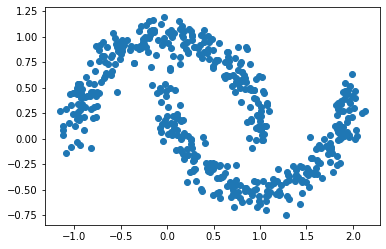

In [98]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

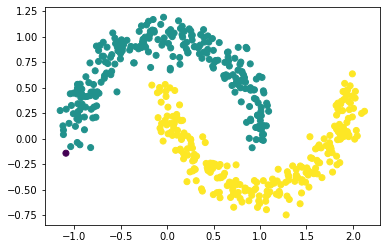

In [100]:
# your code here
clustering = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clustering)
plt.show()

Референс:

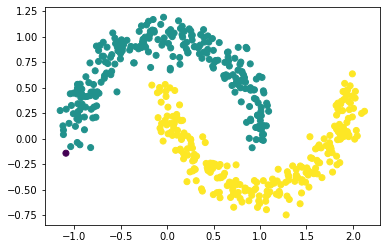

In [99]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



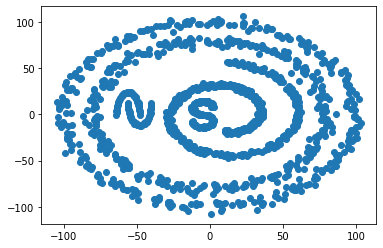

In [ ]:
# your code here


Или хотя бы что-нибудь такое: 

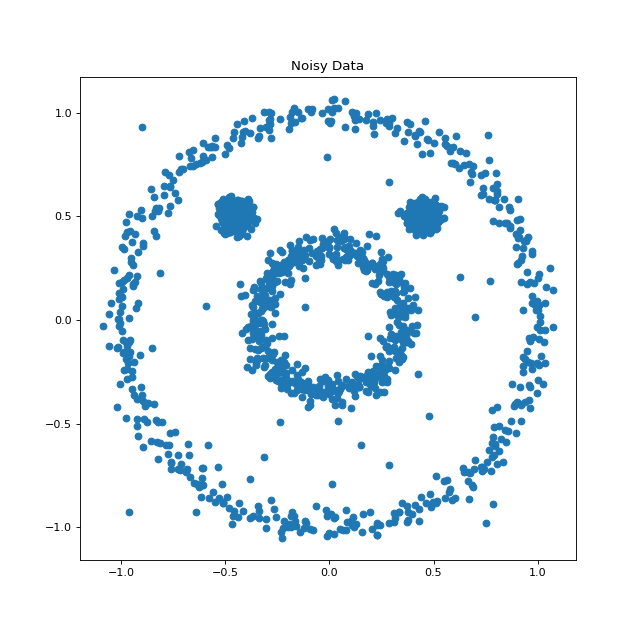

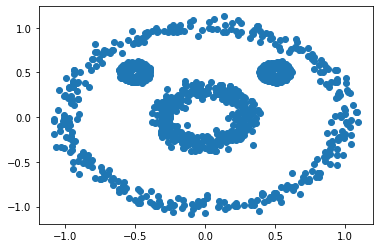

In [102]:
from sklearn.datasets import make_circles
X, _= make_circles(n_samples=700, noise=0.05, factor = 0.3)
X1, _= make_circles(n_samples=500, noise=0.1, factor = 0.6)
X2, _= make_circles(n_samples=500, noise=0.1, factor = 0.6)
X1 = (X1 / 10) + 0.5
X2 = (X2 / 10) + 0.5
X2[:,0] = X2[:,0] - 1
X = np.vstack([X1, X])
X = np.vstack([X2, X])
plt.scatter(X[:,0], X[:,1])
plt.show()

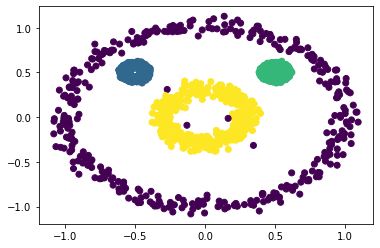

In [105]:
clustering = dbscan(eps=0.08, min_samples=15).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clustering)
plt.show()


> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [174]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 2 ms


In [175]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 194 ms


## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

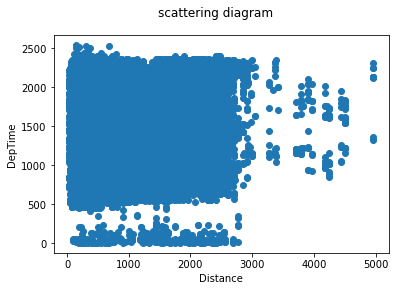

In [3]:
# your code here  ლ(ಠ益ಠლ)
import matplotlib.pyplot as plt
X = train[['Distance', 'DepTime']].values
plt.suptitle('scattering diagram')
plt.xlabel('Distance')
plt.ylabel('DepTime')
plt.scatter(X[:,0], X[:,1])
plt.show()

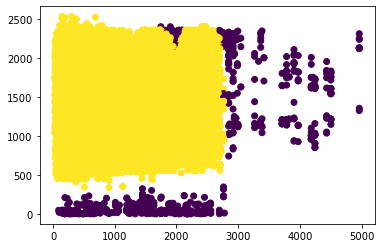

In [4]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=200, min_samples=400).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clustering)
plt.show()

Получился один класс и много шума.

Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

eps = 150 min_samples = 400


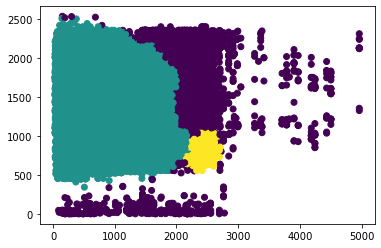

eps = 150 min_samples = 500


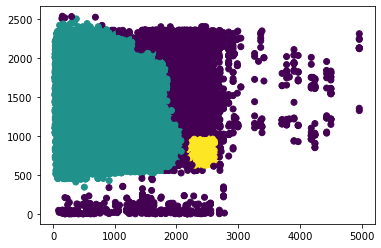

eps = 150 min_samples = 600


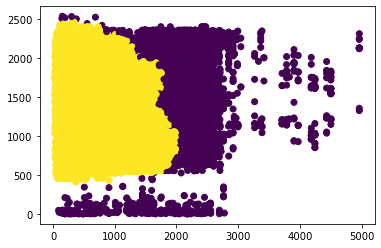

eps = 200 min_samples = 400


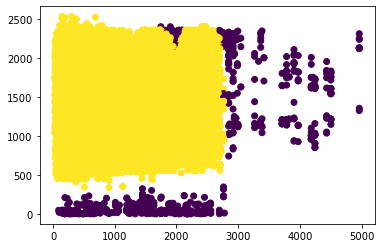

eps = 200 min_samples = 500


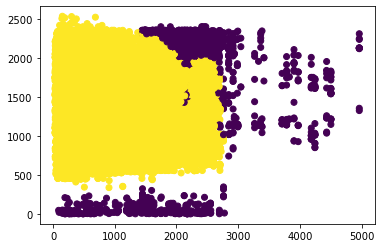

eps = 200 min_samples = 600


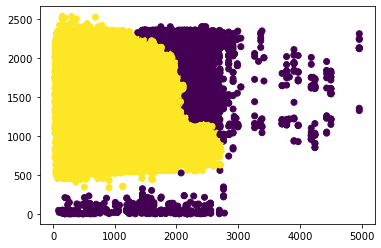

eps = 250 min_samples = 400


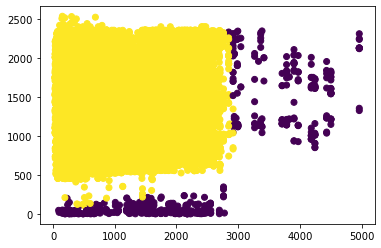

eps = 250 min_samples = 500


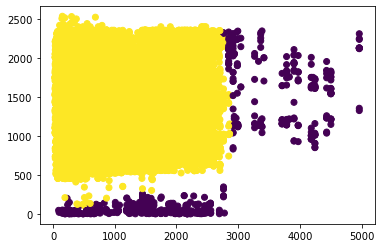

eps = 250 min_samples = 600


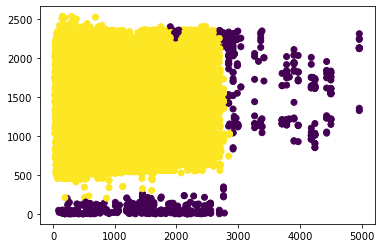

In [14]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆
for eps in [150, 200, 250]:
    for ms in [400, 500, 600]:
        clustering = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
        print('eps =', eps, 'min_samples =', ms)
        plt.scatter(X[:,0], X[:,1], c=clustering)
        plt.show()

Эпсилон - это радиус или минимальный размер кластера. Минимальное кол-во точек и радиус взаимосвязаны. Если нужно много мелких кластеров, то следует выбирать небольшой радиус и небольшое кол-во точек. Если нужны большие кластеры, то нужен большой радиус и большое кол-во точек, но тогда и шум попадет в кластеры.

__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [56]:
# your code here  ¯\_(ツ)_/¯
clustering = DBSCAN(eps=250, min_samples=500).fit_predict(X)
X_train['DBSCAN'] = clustering

In [57]:
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, y_train, test_size=0.3)

In [62]:
cat1 = CatBoostRegressor(n_estimators=50, max_depth=5, learning_rate=0.5, l2_leaf_reg=5)
cat1.fit(X_train_part, y_train_part)
roc_auc_score(y_test_part, cat1.predict(X_test_part))

0:	learn: 0.3821279	total: 11.6ms	remaining: 570ms
1:	learn: 0.3783140	total: 17.1ms	remaining: 410ms
2:	learn: 0.3767594	total: 22.3ms	remaining: 349ms
3:	learn: 0.3758873	total: 27.9ms	remaining: 321ms
4:	learn: 0.3749105	total: 32.4ms	remaining: 292ms
5:	learn: 0.3744508	total: 37.1ms	remaining: 272ms
6:	learn: 0.3739530	total: 42ms	remaining: 258ms
7:	learn: 0.3735264	total: 47.3ms	remaining: 248ms
8:	learn: 0.3731381	total: 52.2ms	remaining: 238ms
9:	learn: 0.3727423	total: 56.8ms	remaining: 227ms
10:	learn: 0.3724061	total: 61.9ms	remaining: 219ms
11:	learn: 0.3721831	total: 66.9ms	remaining: 212ms
12:	learn: 0.3719262	total: 71.8ms	remaining: 204ms
13:	learn: 0.3716991	total: 76.7ms	remaining: 197ms
14:	learn: 0.3715092	total: 81.4ms	remaining: 190ms
15:	learn: 0.3712269	total: 86ms	remaining: 183ms
16:	learn: 0.3708576	total: 90.9ms	remaining: 176ms
17:	learn: 0.3706567	total: 95.4ms	remaining: 170ms
18:	learn: 0.3705242	total: 99.8ms	remaining: 163ms
19:	learn: 0.3704089	total

0.727979530739215

In [63]:
#а теперь уберем столбец кластеризатора и посмотрим на качество
X_train_part = X_train_part.drop('DBSCAN', 1)
X_test_part = X_test_part.drop('DBSCAN', 1)
cat1.fit(X_train_part, y_train_part)
roc_auc_score(y_test_part, cat1.predict(X_test_part))

0:	learn: 0.3816114	total: 36.3ms	remaining: 1.78s
1:	learn: 0.3787579	total: 42.3ms	remaining: 1.01s
2:	learn: 0.3768332	total: 47.2ms	remaining: 739ms
3:	learn: 0.3759147	total: 52.3ms	remaining: 601ms
4:	learn: 0.3750505	total: 57ms	remaining: 513ms
5:	learn: 0.3743198	total: 61.7ms	remaining: 452ms
6:	learn: 0.3738226	total: 66.5ms	remaining: 408ms
7:	learn: 0.3734231	total: 71.6ms	remaining: 376ms
8:	learn: 0.3731648	total: 76.2ms	remaining: 347ms
9:	learn: 0.3727671	total: 81.2ms	remaining: 325ms
10:	learn: 0.3725284	total: 85.7ms	remaining: 304ms
11:	learn: 0.3723000	total: 90.3ms	remaining: 286ms
12:	learn: 0.3721851	total: 94.8ms	remaining: 270ms
13:	learn: 0.3720379	total: 99.2ms	remaining: 255ms
14:	learn: 0.3717585	total: 104ms	remaining: 242ms
15:	learn: 0.3715429	total: 108ms	remaining: 231ms
16:	learn: 0.3713036	total: 113ms	remaining: 220ms
17:	learn: 0.3710158	total: 118ms	remaining: 210ms
18:	learn: 0.3706706	total: 123ms	remaining: 201ms
19:	learn: 0.3705020	total: 1

0.724671061139618

__Ответ:__ Качесто на новых данных лучше, ведь мы помогли классификатору, добавив данные из кластеризатора. Это вносит бОльшую ясность, кластеризатор установил свои зависимости и помог классификатору.

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

<div>
<img src="сдала последнее дз.jpg" width="550"/>
</div>

**+0.1 балла** за смешной мем по машинному обучению

<div>
<img src="мем.jpeg" width="550"/>
</div>

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.

Очень понравился курс! Лектор вдохновил с первых минут, каждую неделю на лекцию как на праздник. Понравилось нарастание сложности. Увлекательные дз, даже не замечала проведенных часов (дней). В выполнении дз помогали семинары. Семинарист не жалеет своего времени, старается подробно рассказать тему. Больше всего мне понравилось импортировать готовые методы))) Но тем не менее, очень приятно осознавать, что смог реализвать градиентный спуск/решающее дерево/бустинг своими ручками. Даже кр была совсем не страшной, лектор не обманул. В общем, только приятные впечатления. Спасибо за курс! С нетерпением жду нового семестра!